# Convolutional Variational Autoencoder

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import sys,os,glob
sys.path.append('util/')
from util import plotProgress

from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))
K.get_session().run(tf.global_variables_initializer())

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [3]:
epochs=50
batch=128
latent_dim=2
inter_dim=128
optimizer='adam'
filters=[8,16]
kernel_size=5
rate_recon=0.999999

In [4]:
def sampling(args):
    z_mean,z_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),mean=0,stddev=1)
    return z_mean+K.exp(z_log_var/2)*epsilon

In [5]:
def lossVAE(z_mean, z_sigma_log):
    def loss(tensor_input, tensor_decode):
        loss_recon =  metrics.binary_crossentropy(K.flatten(tensor_input), K.flatten(tensor_decode))
        loss_KL = - 0.5 * K.sum(1 + z_sigma_log - K.square(z_mean) - K.exp(z_sigma_log), axis=-1)
        return rate_recon*loss_recon + (1-rate_recon)*loss_KL
    return loss

In [6]:
#Build Encoder
input_img = Input(shape=X_train.shape[1:])
x = input_img
for fil in filters:
    x = Conv2D(filters = fil,
             kernel_size = kernel_size,
             activation = 'relu',
             padding = 'same',
             strides = 1)(x)
shape = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim,activation = 'linear')(x)
z_log_var = Dense(latent_dim,activation = 'linear')(x)

encoder = Model(input_img,z_mean)
encoder.summary()

# Sampling
z = Lambda(sampling,output_shape = (latent_dim,))([z_mean,z_log_var])

# Build Decoder
latent = Input(shape = (latent_dim,))
x = Dense(shape[1]*shape[2]*shape[3],activation = 'relu')(latent)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for fil in filters[::-1]:
    x = Conv2DTranspose(filters = fil,
                      kernel_size = kernel_size,
                      activation = 'relu',
                      strides = 1,
                      padding = 'same')(x)
outputs = Conv2DTranspose(filters = 1,
                        kernel_size = kernel_size,
                        activation = 'sigmoid',
                        padding = 'same')(x)

decoder = Model(latent,outputs)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        3216      
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 25090     
Total params: 28,514
Trainable params: 28,514
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.2471 - val_loss: 0.2053
Epoch 2/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.2003 - val_loss: 0.1955
Epoch 3/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1944 - val_loss: 0.1920
Epoch 4/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1919 - val_loss: 0.1901
Epoch 5/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1905 - val_loss: 0.1897
Epoch 6/50
60000/60000 [==============================] - 5s 91us/step - loss: 0.1891 - val_loss: 0.1884
Epoch 7/50
60000/60000 [==============================] - 5s 76us/step - loss: 0.1882 - val_loss: 0.1878
Epoch 8/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.1875 - val_loss: 0.1872
Epoch 9/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1868 - val_loss: 0.1869
Epoc

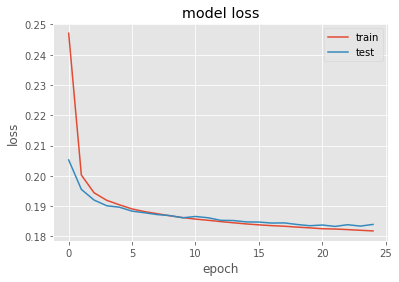

In [7]:
autoencoder = Model(input_img,decoder(z))
autoencoder.compile(optimizer = optimizer,loss = lossVAE(z_mean,z_log_var))
es_cb = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'auto')
history = autoencoder.fit(X_train, X_train,
                epochs = epochs,
                batch_size = batch,
                shuffle = True,
                callbacks = [es_cb],
                validation_data = (X_test,X_test))
plotProgress(history)

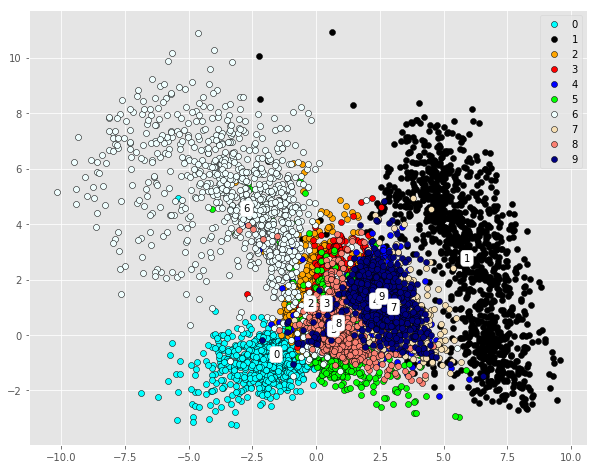

In [8]:
pred = encoder.predict(X_test)
cmap = ['cyan','black','orange','red','blue','lime','azure','wheat','salmon','navy']
fig,ax = plt.subplots(figsize = (10,8))
for i in range(10):
    ax.scatter(pred[y_test == i,0],pred[y_test == i,1],
                edgecolors = 'black',
                c = cmap[i],
                label = str(i))
    ax.annotate(str(i),(pred[y_test == i,0].mean(),pred[y_test == i,1].mean()),
               bbox = dict(boxstyle = "round", fc = "w"))
plt.legend()

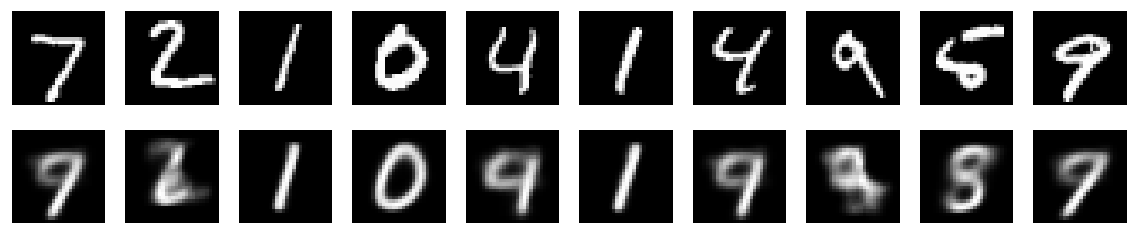

In [9]:
# get decoded digits
reconstructed = decoder.predict(pred)
# plot decoded
n = 10
plt.figure(figsize = (20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i+0*n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i+0*n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()